MongoDB에서 받아온 데이터로 리턴 계산

In [1]:
import os 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from tqdm import tqdm

In [3]:
price_df = pd.read_csv("mongo_price.csv", index_col=0, 
                       parse_dates= True)
market_cap_df = pd.read_csv("mongo_mkt.csv", index_col=0,
                            parse_dates=True)

In [4]:
# 시총으로 weight를 계산
weight = market_cap_df.apply(lambda x: x / np.nansum(x), axis=1)

# 수익률 데이터프레임 생성
return_df1 = price_df.pct_change()
return_df7 = price_df.pct_change(7)

In [113]:
# Problems 제거 -> 리턴에 inf가 찍혀있는 것들
s_bool = ((return_df1 * weight) > 10000)

# Problem을 찾고
sum_df = s_bool.sum(axis=0)
problem_coin_lst = list(sum_df.loc[sum_df >= 1].index)

# Problem 코인을 Drop 한다
weight.drop(problem_coin_lst, axis=1, inplace=True)
return_df1.drop(problem_coin_lst, axis=1, inplace=True)
return_df7.drop(problem_coin_lst, axis=1, inplace=True)
market_cap_df.drop(problem_coin_lst, axis=1, inplace=True)

In [115]:
# 시총으로 screening (1,000,000달러 이상)
screener = np.where(market_cap_df > 1_000_000, 1, np.nan)
screener_df = pd.DataFrame(screener, index=market_cap_df.index,
                           columns=market_cap_df.columns)

# 스크리닝 후, 스크린한 것들로만 시가총액 가중 weight를 구함
screened_weight = (screener_df * market_cap_df).apply(lambda x: x / np.nansum(x), axis=1)

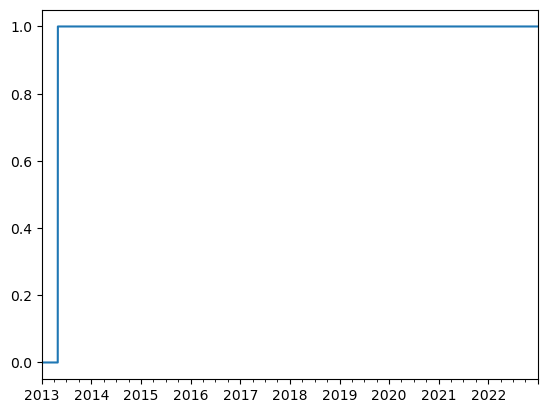

In [116]:
screened_weight.sum(axis=1).plot();

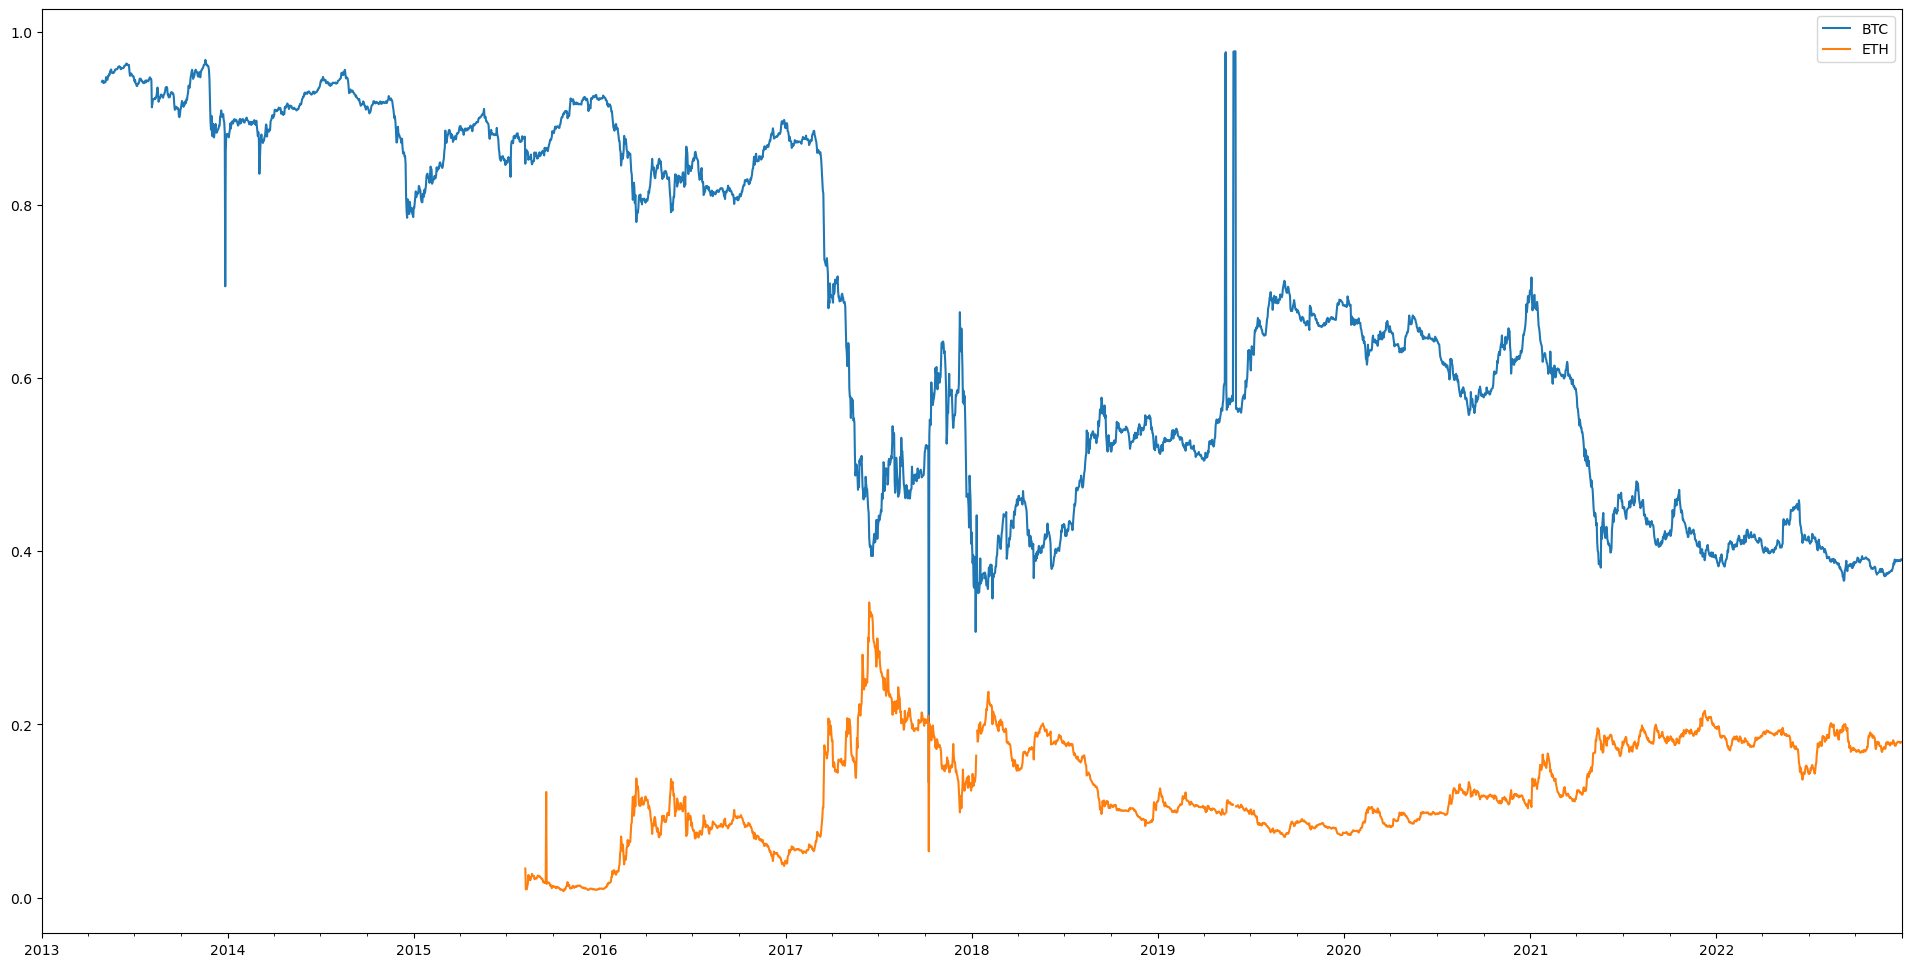

In [117]:
screened_weight[["BTC", "ETH"]].plot(figsize=(24,12));

In [118]:
pd.set_option("display.max_rows", 100)

In [136]:
screened_weight[["BTC", "ETH"]].loc[(screened_weight[["BTC", "ETH"]] >= 0.96).sum(axis=1).astype("bool")]#.plot(figsize=(24,12));

,BTC,ETH
2013-06-02,0.960217,NaN
2013-06-12,0.960799,NaN
2013-06-13,0.960796,NaN
2013-06-14,0.961200,NaN
2013-06-15,0.962345,NaN
2013-06-16,0.963367,NaN
2013-06-17,0.962676,NaN
2013-06-18,0.961601,NaN
2013-06-19,0.962139,NaN
2013-06-20,0.960983,NaN


In [152]:
# 상장된 코인 수가 중간에 0이 되는 데이터 문제 수정을 위해서
market_cap_df_ffill = market_cap_df.ffill()

# 시총으로 screening (1,000,000달러 이상)
screener = np.where(market_cap_df_ffill > 1_000_000_000, 1, np.nan)
screener_df = pd.DataFrame(screener, index=market_cap_df_ffill.index,
                           columns=market_cap_df_ffill.columns)

# 스크리닝 후, 스크린한 것들로만 시가총액 가중 weight를 구함
screened_weight = (screener_df * market_cap_df_ffill).apply(lambda x: x / np.nansum(x), axis=1)

In [153]:
screened_weight[["BTC", "ETH"]].loc[(screened_weight[["BTC", "ETH"]] >= 0.96).sum(axis=1).astype("bool")]#.plot(figsize=(24,12));

,BTC,ETH
2013-04-29,1.0,NaN
2013-04-30,1.0,NaN
2013-05-01,1.0,NaN
2013-05-02,1.0,NaN
2013-05-03,1.0,NaN
...,...,...
2017-01-31,1.0,NaN
2017-02-01,1.0,NaN
2017-02-02,1.0,NaN
2017-02-03,1.0,NaN


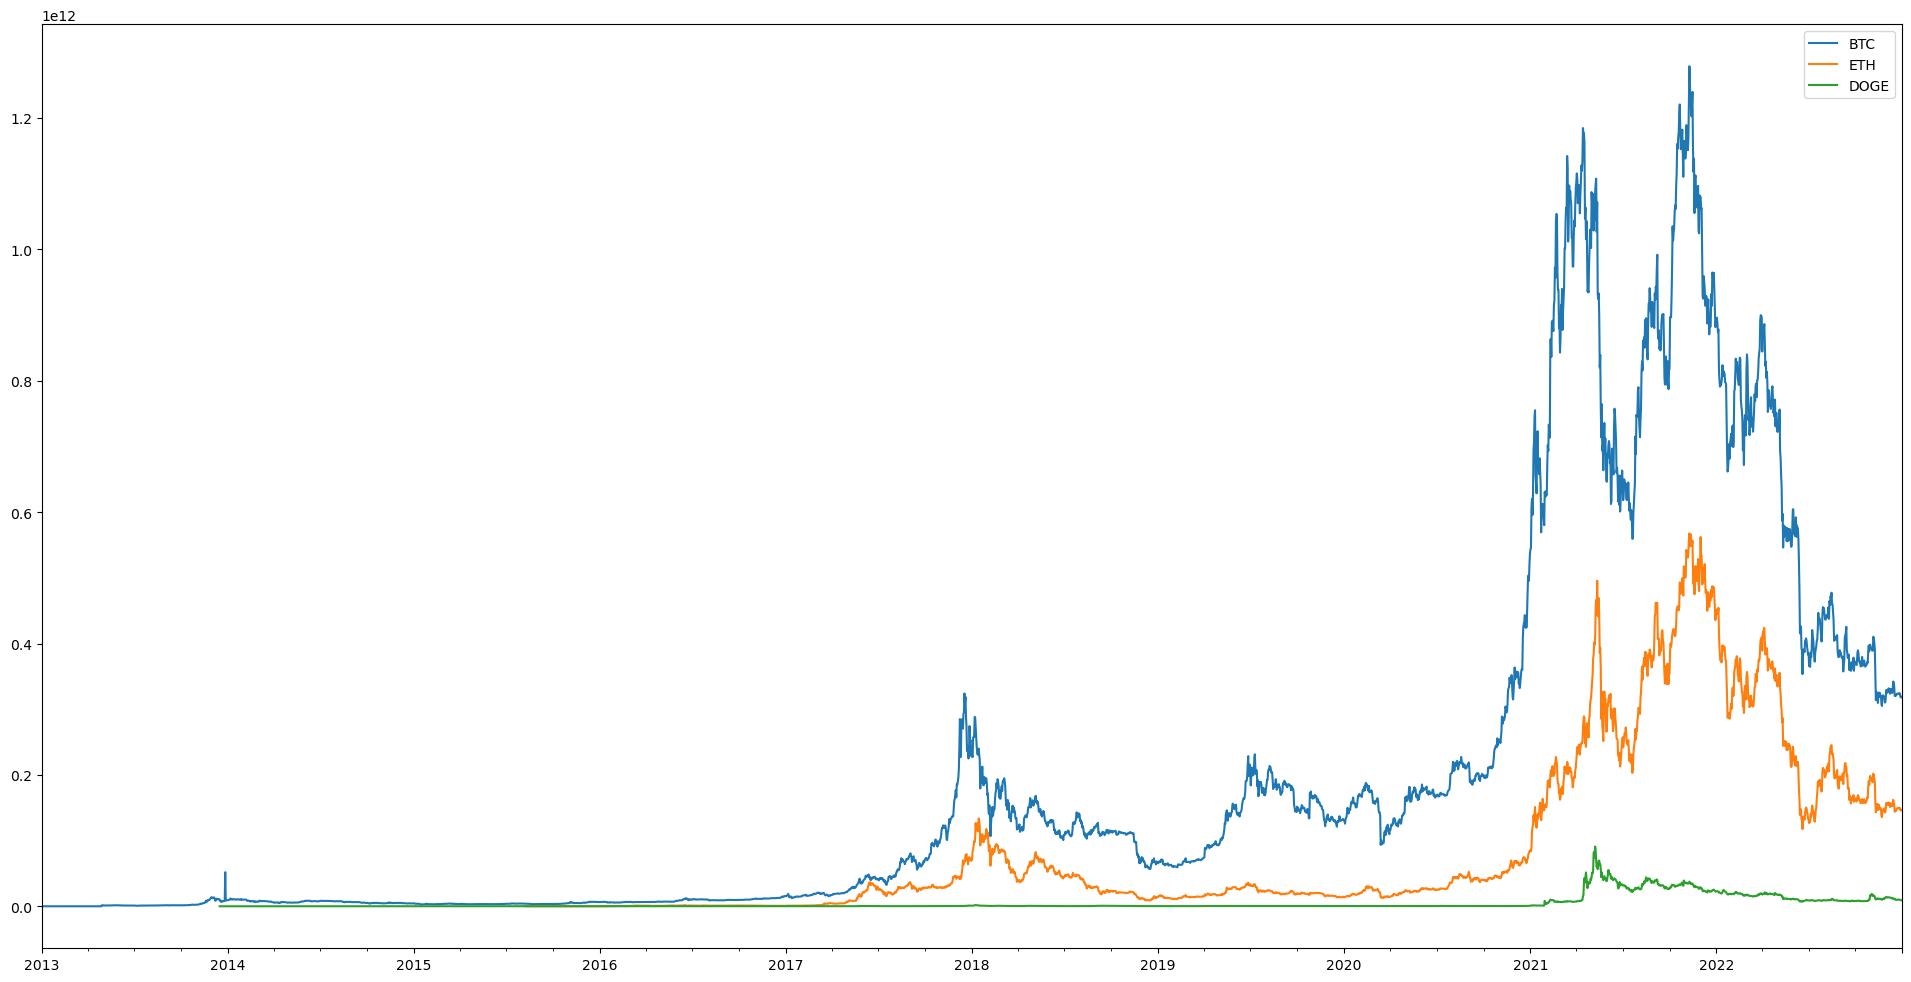

In [154]:
market_cap_df_ffill[["BTC","ETH", "DOGE"]].plot(figsize=(24,12));

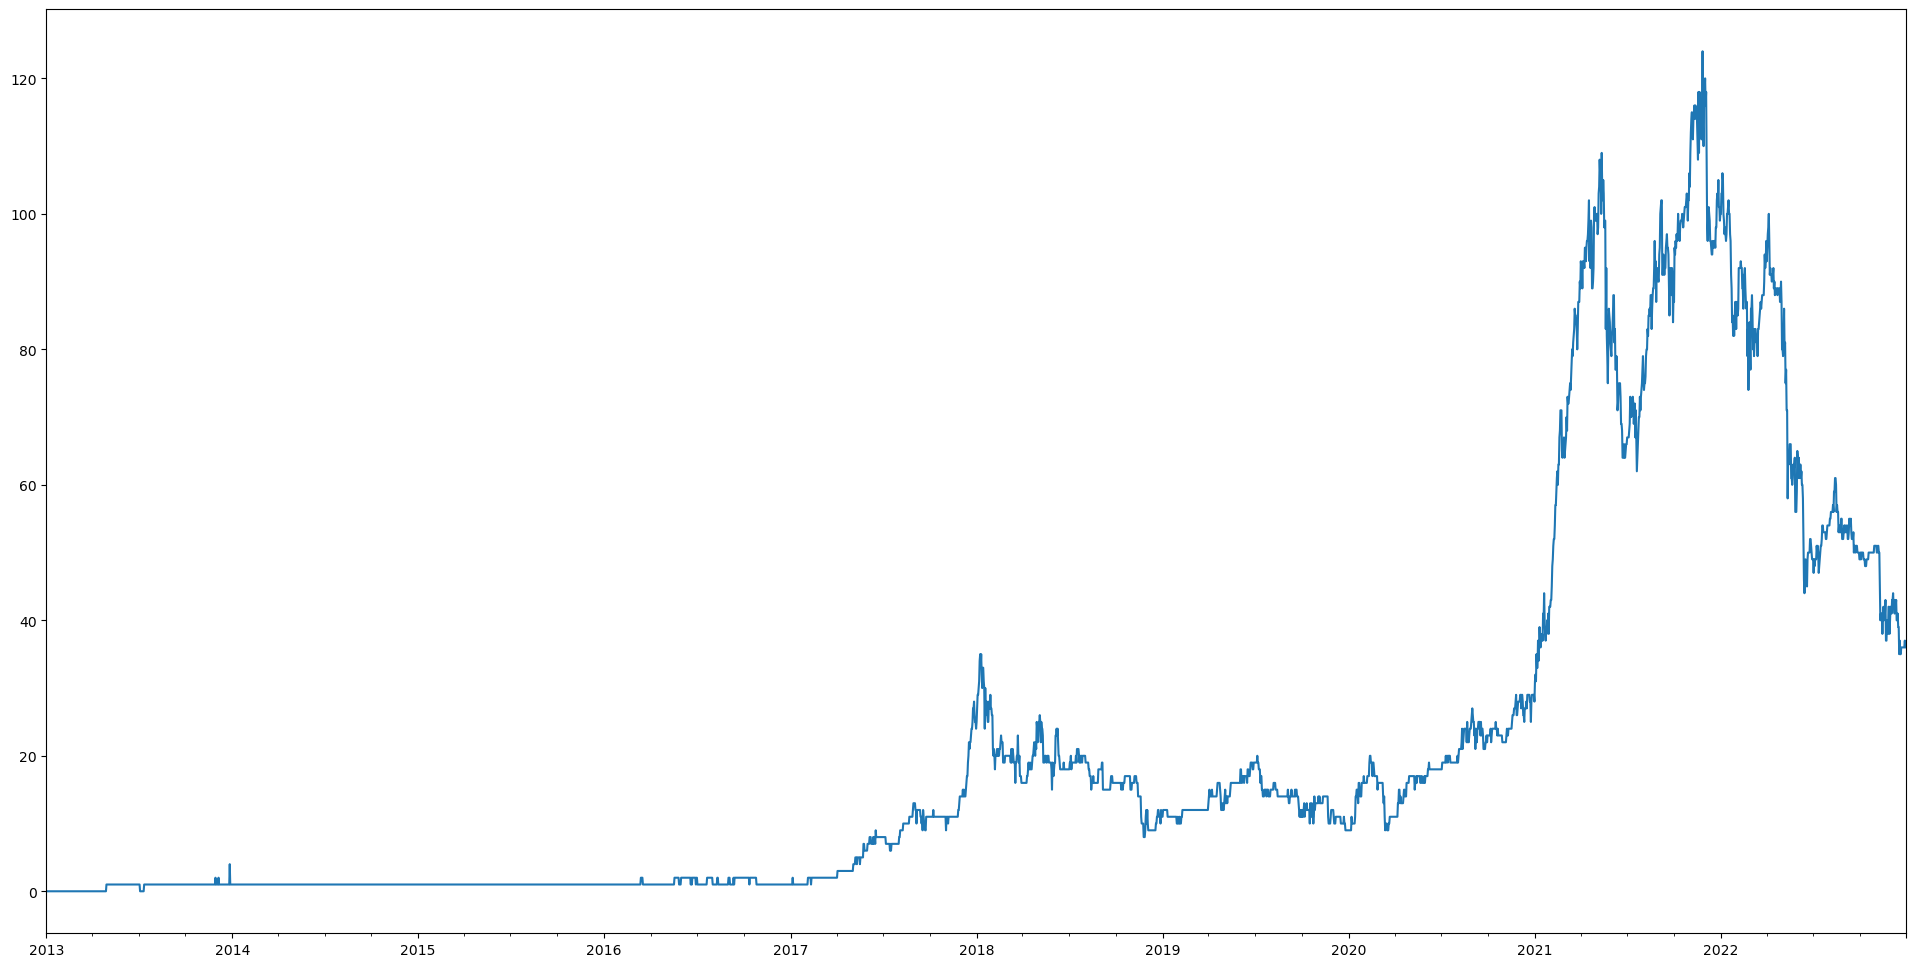

In [155]:
# ffill을 하고, 스크리닝 한 종목 수를 출력 (수익률 아님!!)
screener_df.count(axis=1).plot(figsize=(24,12));

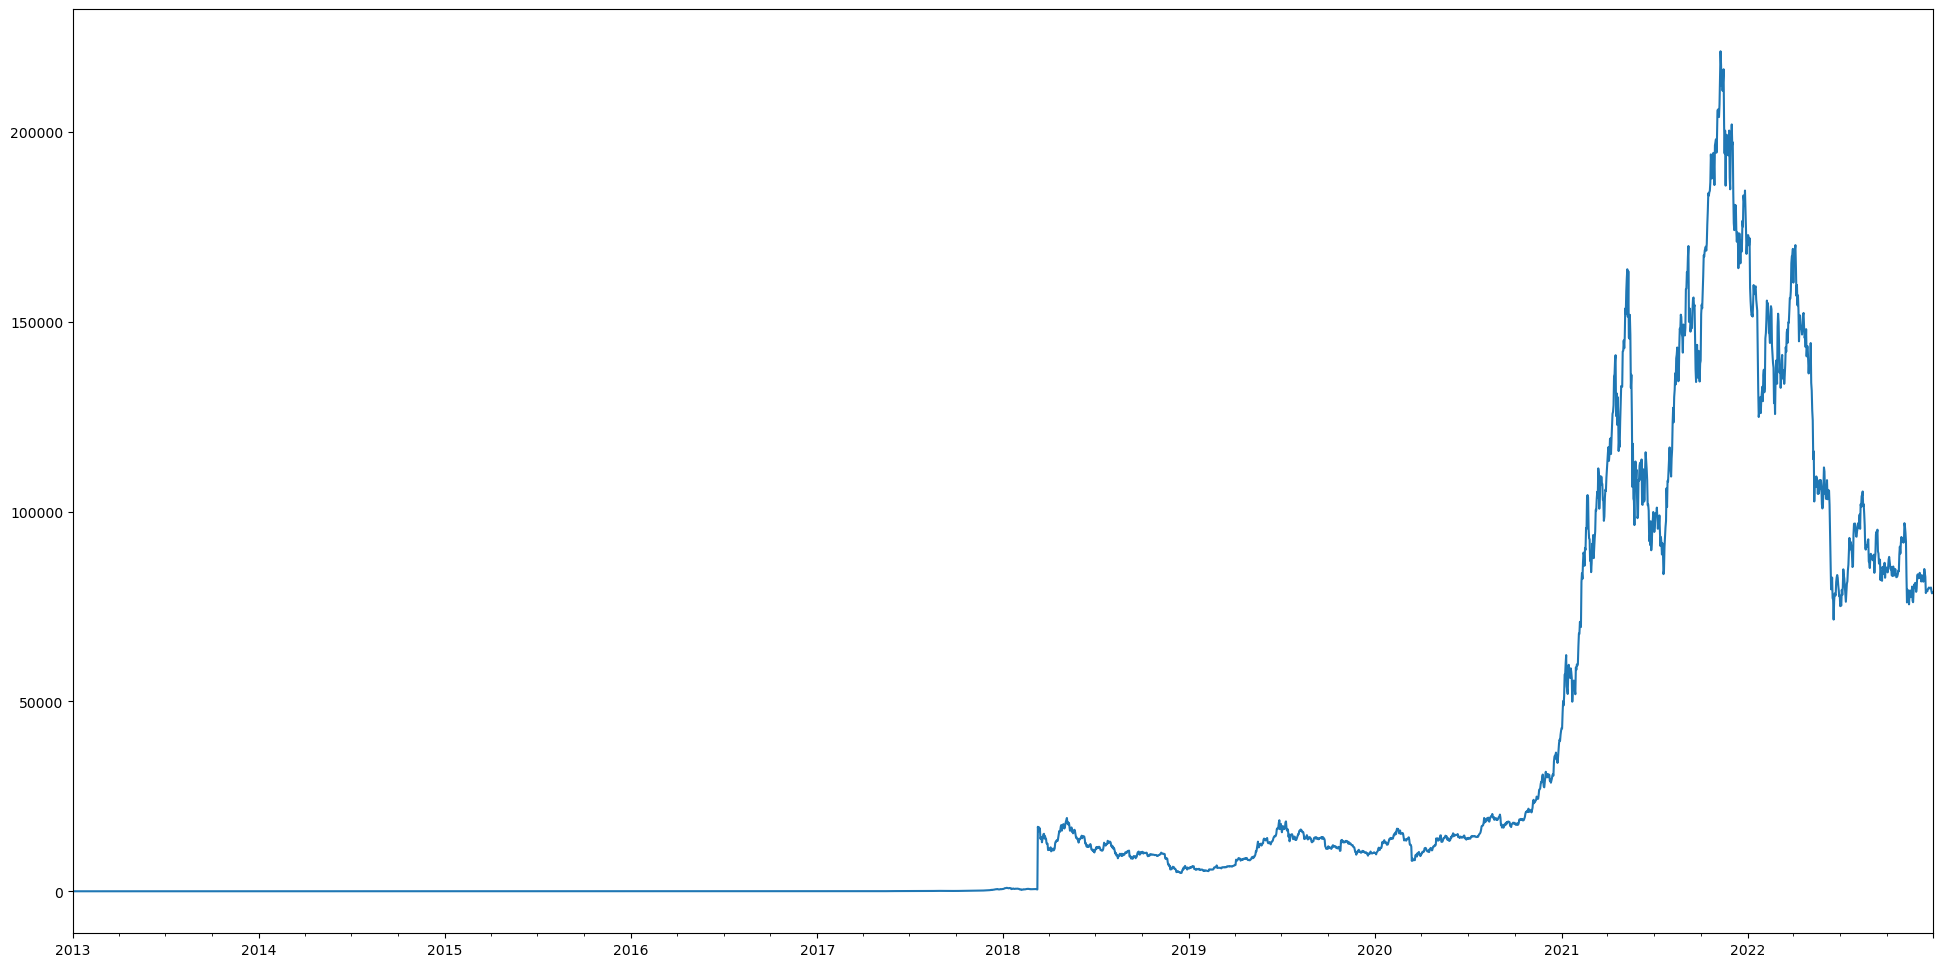

In [156]:
# 스크리닝하고, 시가총액으로 가중평균한 수익률
((return_df1 * screened_weight).sum(axis=1) + 1) \
                               .cumprod()  \
                               .loc[:"2022"] \
                               .plot(figsize=(24,12));